In [22]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import time
import os
import boto3
import sagemaker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sagemaker.amazon.amazon_estimator import get_image_uri
import io
import sagemaker.amazon.common as smac
import scipy.sparse as sp
from sklearn.preprocessing import LabelEncoder
import json
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
role = sagemaker.get_execution_role()

sess = sagemaker.Session()
bucket = "gcu-sg02-007-ml2"
prefix = "builtin-notebooks/Recomendation-Machine/Explicit2"
print(f"role: {role} bucket: {bucket}")

train_key = 'train.protobuf'
train_prefix = '{}/{}'.format(prefix, 'train')
s3_train = 's3://{}/{}/train/'.format(bucket,prefix)

test_key = 'test.protobuf'
test_prefix = '{}/{}'.format(prefix, 'test')

#ubicación S3 de salida
output_prefix = 's3://{}/{}/output'.format(bucket, prefix)
my_region = boto3.session.Session().region_name

print(my_region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
role: arn:aws:iam::629515838455:role/service-role/AmazonSageMaker-ExecutionRole-20231201T000262 bucket: gcu-sg02-007-ml2
ap-northeast-2


In [3]:
col_name = ["User_ID", "Stream_ID", "Streamer_username", "Time_start", "Time_stop"]
df = pd.read_csv('./100k_a.csv',header = None, names = col_name)
df.head()

,User_ID,Stream_ID,Streamer_username,Time_start,Time_stop
0,1,33842865744,mithrain,154,156
1,1,33846768288,alptv,166,169
2,1,33886469056,mithrain,587,588
3,1,33887624992,wtcn,589,591
4,1,33890145056,jrokezftw,591,594


In [4]:
print("최대 측정 시간 : " + str(df["Time_stop"].max()))
print("최소 측정 시간 : " + str(df["Time_start"].min()))

최대 측정 시간 : 6148
최소 측정 시간 : 0


In [5]:
# rating 추가

df["rating"] = (df["Time_stop"] - df["Time_start"]) * 10
df.head()

,User_ID,Stream_ID,Streamer_username,Time_start,Time_stop,rating
0,1,33842865744,mithrain,154,156,20
1,1,33846768288,alptv,166,169,30
2,1,33886469056,mithrain,587,588,10
3,1,33887624992,wtcn,589,591,20
4,1,33890145056,jrokezftw,591,594,30


In [6]:
# User_ID와 Streamer_username 기준으로 그룹화하여 rating 합산
df = df.groupby(['User_ID', 'Streamer_username']).agg({'rating': 'sum'}).reset_index()

df

,User_ID,Streamer_username,rating
0,1,alptv,30
1,1,berkriptepe,30
2,1,elraenn,20
3,1,eraymaskulen,10
4,1,esl_csgo,10
...,...,...,...
1505153,100000,mckytv,10
1505154,100000,natehill,10
1505155,100000,ninja,30
1505156,100000,replays,10


In [7]:
print(df["rating"].min())
print(df["rating"].max())

10
6340


In [8]:
# if rating >= threshod rating_bin = 1 not rating_bin = 0 
time_threshold = 30
df['rating_bin'] = (df.rating>=time_threshold).astype('float32')
df = df.drop(['rating'], axis=1)
df

,User_ID,Streamer_username,rating_bin
0,1,alptv,1.0
1,1,berkriptepe,1.0
2,1,elraenn,0.0
3,1,eraymaskulen,0.0
4,1,esl_csgo,0.0
...,...,...,...
1505153,100000,mckytv,0.0
1505154,100000,natehill,0.0
1505155,100000,ninja,1.0
1505156,100000,replays,0.0


In [9]:
print(sum(df['rating_bin'] == 1))
print(sum(df['rating_bin'] == 0))

691125
814033


In [10]:
# sampling 100000
df = df.sample(n=100000, random_state=42)

In [11]:
print(sum(df['rating_bin'] == 1))
print(sum(df['rating_bin'] == 0))

45776
54224


In [12]:
# 데이터를 학습용과 테스트용으로 분할 (예: 80% 학습, 20% 테스트)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [13]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=True)
enc.fit(df[['User_ID','Streamer_username']])

X_train_OH = enc.transform(train_df[['User_ID','Streamer_username']]).astype('float32')
Y_train_OH = train_df['rating_bin'].astype('float32')  

X_test_OH = enc.transform(test_df[['User_ID','Streamer_username']]).astype('float32')
Y_test_OH = test_df['rating_bin'].astype('float32')  

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
# User_ID와 Streamer_username의 고유한 값 확인
user_ids = enc.categories_[0]  # 첫 번째 열 (User_ID)의 고유한 값들
streamer_usernames = enc.categories_[1]  # 두 번째 열 (Streamer_username)의 고유한 값들

# 고유한 값들 출력
print("User_IDs:", user_ids)
print("Streamer_usernames:", streamer_usernames)


User_IDs: [     2      7     14 ...  99997  99999 100000]
Streamer_usernames: ['030_hi' '080808080' '0_doublezero_0' ... 'zzzerrr' 'zzzireael'
 'zzztantrikazzz']


In [15]:
print(Y_train_OH.sort_index())
print(Y_test_OH.sort_index())

0        1.0
1        0.0
2        1.0
3        1.0
4        0.0
        ... 
79995    1.0
79996    1.0
79997    0.0
79998    1.0
79999    0.0
Name: rating_bin, Length: 80000, dtype: float32
0        1.0
1        0.0
2        0.0
3        1.0
4        1.0
        ... 
19995    0.0
19996    1.0
19997    0.0
19998    1.0
19999    0.0
Name: rating_bin, Length: 20000, dtype: float32


In [16]:
columns = X_train_OH.shape[1]

print("Columns:{} ".format(X_train_OH.shape[1]))
print("Rows:{} ".format(X_train_OH.shape[0]))

Columns:82636 
Rows:80000 


In [17]:
def writeDatasetToProtobuf(X, Y, bucket, prefix, key):
    buf = io.BytesIO()
    # Y = Y.reset_index(drop=True)
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket, obj)
  
train_data = writeDatasetToProtobuf(X_train_OH, Y_train_OH, bucket, train_prefix, train_key)    
test_data = writeDatasetToProtobuf(X_test_OH, Y_test_OH, bucket, test_prefix, test_key)    
  
print(train_data)
print(test_data)
print('Output: {}'.format(output_prefix))

s3://gcu-sg02-007-ml2/builtin-notebooks/Recomendation-Machine/Explicit2/train/train.protobuf
s3://gcu-sg02-007-ml2/builtin-notebooks/Recomendation-Machine/Explicit2/test/test.protobuf
Output: s3://gcu-sg02-007-ml2/builtin-notebooks/Recomendation-Machine/Explicit2/output


In [18]:
# sagemaker model
instance_type='ml.m5.large'
fm = sagemaker.estimator.Estimator(get_image_uri(boto3.Session().region_name, "factorization-machines"),
                                   role, 
                                   train_instance_count=1, 
                                   train_instance_type=instance_type,
                                   output_path=output_prefix,
                                   sagemaker_session=sagemaker.Session())

fm.set_hyperparameters(feature_dim=columns,
                      predictor_type='binary_classifier',
                      mini_batch_size=1000,
                      num_factors=64,
                      epochs=100)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [19]:
data_channels = {
    "train": train_data,
    "test": test_data
}

# train
fm.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: factorization-machines-2023-12-01-05-01-30-439


2023-12-01 05:01:30 Starting - Starting the training job...
2023-12-01 05:01:45 Starting - Preparing the instances for training......
2023-12-01 05:02:54 Downloading - Downloading input data......
2023-12-01 05:03:39 Training - Downloading the training image......
2023-12-01 05:04:50 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[12/01/2023 05:04:57 INFO 140516319254336] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-conf.json: {'epochs': 1, 'mini_batch_size': '1000', 'use_bias': 'true', 'use_linear': 'true', 'bias_lr': '0.1', 'linear_lr': '0.001', 'factors_lr': '0.0001', 'bias_wd': '0.01', 'linear_wd': '0.001', 'factors_wd': '0.00001', 'bias_init_method

In [20]:
# endpoint
endpoint_name = 'sg-factorization-classifier'
fm_predictor = fm.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    endpoint_name=endpoint_name
)

endpoint_name = fm_predictor.endpoint_name
print(f"Endpoints name: {endpoint_name}")


INFO:sagemaker:Creating model with name: factorization-machines-2023-12-01-05-07-14-953
INFO:sagemaker:Creating endpoint-config with name sg-factorization-classifier
INFO:sagemaker:Creating endpoint with name sg-factorization-classifier


------!Endpoints name: sg-factorization-classifier


In [21]:
buf = io.BytesIO()
smac.write_spmatrix_to_sparse_tensor(buf, X_test_OH.astype('float32'))
buf.seek(0)

# make SageMaker client
client = boto3.client('runtime.sagemaker')

# predict
response = client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType='application/x-recordio-protobuf',
    Body=buf.read()
)

# result
predictions = json.loads(response['Body'].read().decode())


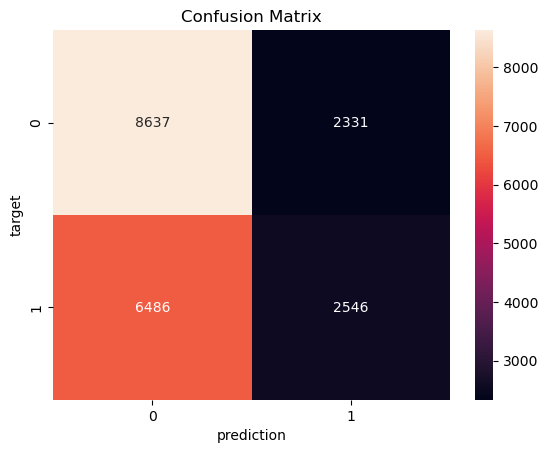

Precision: 0.5220422390814025
Recall: 0.28188662533215236
F1 Score: 0.3660938960385362


In [23]:
# predict result change list
predictions_list = [pred['predicted_label'] for pred in predictions["predictions"]]

predictions_array = np.array(predictions_list)
Y_test_array = Y_test_OH.values

cm = confusion_matrix(Y_test_array, predictions_array)

# confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('target')
plt.xlabel('prediction')
plt.title('Confusion Matrix')
plt.show()

f1 = f1_score(Y_test_array, predictions_array)
# Precision
precision = precision_score(Y_test_array, predictions_array)
# Recall
recall = recall_score(Y_test_array, predictions_array)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [84]:
# fm_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sg-factorization-classifier
INFO:sagemaker:Deleting endpoint with name: sg-factorization-classifier
